In [1]:


## Imports
import torch
import torchvision ## Contains some utilities for working with the image data
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
#%matplotlib inline
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn




In [2]:
dataset = MNIST(root = 'data/', download = True)
print(len(dataset))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:05<00:00, 1883281.88it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 199879.70it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1532694.80it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10090322.44it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000


Label: 0


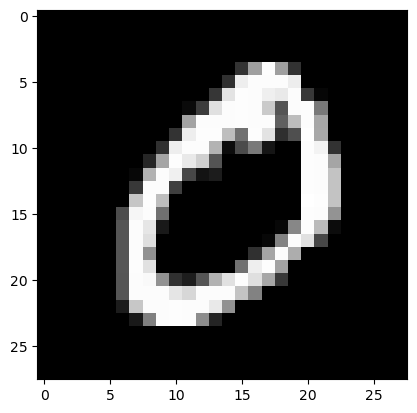

In [4]:
image, label = dataset[1]
plt.imshow(image, cmap = 'gray')
print('Label:', label)

In [7]:
type(image)

PIL.Image.Image

In [8]:


## MNIST dataset(images and labels)
mnist_dataset = MNIST(root = 'data/', train = True, transform = transforms.ToTensor())
print(mnist_dataset)



Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [10]:

image_tensor, label = mnist_dataset[0]
print(image_tensor.shape, label)

torch.Size([1, 28, 28]) 5


In [11]:

print(image_tensor[:,10:15,10:15])
print(torch.max(image_tensor), torch.min(image_tensor))

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


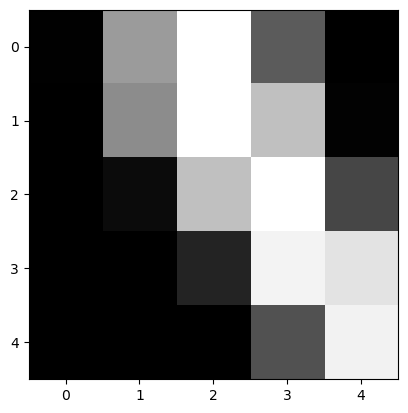

In [12]:
## Plot the image of the tensor
plt.imshow(image_tensor[0,10:15,10:15],cmap = 'gray')

In [13]:
train_data, validation_data = random_split(mnist_dataset, [50000, 10000])
## Print the length of train and validation datasets
print("length of Train Datasets: ", len(train_data))
print("length of Validation Datasets: ", len(validation_data))

length of Train Datasets:  50000
length of Validation Datasets:  10000


In [14]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle = True)
val_loader = DataLoader(validation_data, batch_size, shuffle = False)

In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return(torch.tensor(torch.sum(preds == labels).item()/ len(preds)))

In [19]:
input_size = 28 * 28
num_classes = 10

class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return(out)
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images) ## Generate predictions
        loss = F.cross_entropy(out, labels) ## Calculate the loss
        return(loss)
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return({'val_loss':loss, 'val_acc': acc})
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'val_loss': epoch_loss.item(), 'val_acc' : epoch_acc.item()})
    
    def epoch_end(self, epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        
    
model = MnistModel()



In [23]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return(model.validation_epoch_end(outputs))

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        ## Training Phas
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        ## Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return(history)

In [24]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.3074228763580322, 'val_acc': 0.08109176903963089}

In [25]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9411, val_acc: 0.6485
Epoch [1], val_loss: 1.6728, val_acc: 0.7356
Epoch [2], val_loss: 1.4730, val_acc: 0.7649
Epoch [3], val_loss: 1.3225, val_acc: 0.7840
Epoch [4], val_loss: 1.2067, val_acc: 0.7971


In [26]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1158, val_acc: 0.8070
Epoch [1], val_loss: 1.0431, val_acc: 0.8142
Epoch [2], val_loss: 0.9835, val_acc: 0.8198
Epoch [3], val_loss: 0.9340, val_acc: 0.8251
Epoch [4], val_loss: 0.8921, val_acc: 0.8292


In [27]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8563, val_acc: 0.8327
Epoch [1], val_loss: 0.8252, val_acc: 0.8356
Epoch [2], val_loss: 0.7980, val_acc: 0.8381
Epoch [3], val_loss: 0.7740, val_acc: 0.8415
Epoch [4], val_loss: 0.7526, val_acc: 0.8435


In [28]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7335, val_acc: 0.8453
Epoch [1], val_loss: 0.7162, val_acc: 0.8469
Epoch [2], val_loss: 0.7005, val_acc: 0.8489
Epoch [3], val_loss: 0.6862, val_acc: 0.8510
Epoch [4], val_loss: 0.6730, val_acc: 0.8527


Text(0.5, 1.0, 'Accuracy Vs. No. of epochs')

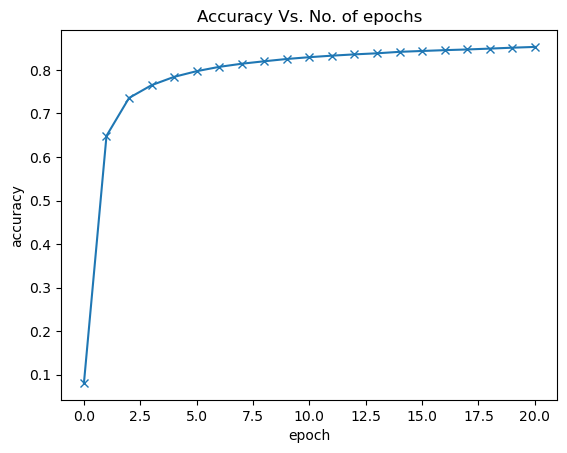

In [29]:
## Replace these values with your result
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Vs. No. of epochs')